# Can you find a better way to segment your customers?

## 📖 Background
You work for a medical device manufacturer in Switzerland. Your company manufactures orthopedic devices and sells them worldwide. The company sells directly to individual doctors who use them on rehabilitation and physical therapy patients.

Historically, the sales and customer support departments have grouped doctors by geography. However, the region is not a good predictor of the number of purchases a doctor will make or their support needs.

Your team wants to use a data-centric approach to segmenting doctors to improve marketing, customer service, and product planning. 

## 💾 The data

The company stores the information you need in the following four tables. Some of the fields are anonymized to comply with privacy regulations.

#### Doctors contains information on doctors. Each row represents one doctor.
- "DoctorID" - is a unique identifier for each doctor.
- "Region" - the current geographical region of the doctor.
- "Category" - the type of doctor, either 'Specialist' or 'General Practitioner.'
- "Rank" - is an internal ranking system. It is an ordered variable: The highest level is Ambassadors, followed by Titanium Plus, Titanium, Platinum Plus, Platinum, Gold Plus, Gold, Silver Plus, and the lowest level is Silver.
- "Incidence rate"  and "R rate" - relate to the amount of re-work each doctor generates.
- "Satisfaction" - measures doctors' satisfaction with the company.
- "Experience" - relates to the doctor's experience with the company.
- "Purchases" - purchases over the last year.

#### Orders contains details on orders. Each row represents one order; a doctor can place multiple orders.
- "DoctorID" - doctor id (matches the other tables).
- "OrderID" - order identifier.
- "OrderNum" - order number.
- "Conditions A through J" - map the different settings of the devices in each order. Each order goes to an individual patient.

#### Complaints collects information on doctor complaints.
- "DoctorID" - doctor id (matches the other tables).
- "Complaint Type" - the company's classification of the complaints.
- "Qty" - number of complaints per complaint type per doctor.

#### Instructions has information on whether the doctor includes special instructions on their orders.
- "DoctorID" - doctor id (matches the other tables).
- "Instructions" - 'Yes' when the doctor includes special instructions, 'No' when they do not.

## 💪 Competition challenge

Create a report that covers the following:
1. How many doctors are there in each region? What is the average number of purchases per region?
2. Can you find a relationship between purchases and complaints?
3. Define new doctor segments that help the company improve marketing efforts and customer service.
4. Identify which features impact the new segmentation strategy the most.
5. Your team will need to explain the new segments to the rest of the company. Describe which characteristics distinguish the newly defined segments.

## 🧑‍⚖️ Judging criteria

| CATEGORY | WEIGHTING | DETAILS                                                              |
|:---------|:----------|:---------------------------------------------------------------------|
| **Recommendations** | 35%       | <ul><li>Clarity of recommendations - how clear and well presented the recommendation is.</li><li>Quality of recommendations - are appropriate analytical techniques used & are the conclusions valid?</li><li>Number of relevant insights found for the target audience.</li></ul>       |
| **Storytelling**  | 35%       | <ul><li>How well the data and insights are connected to the recommendation.</li><li>How the narrative and whole report connects together.</li><li>Balancing making the report in-depth enough but also concise.</li></ul> |
| **Visualizations** | 20% | <ul><li>Appropriateness of visualization used.</li><li>Clarity of insight from visualization.</li></ul> |
| **Votes** | 10% | <ul><li>Up voting - most upvoted entries get the most points.</li></ul> |

In [395]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler

In [250]:
#Matplot lib configurations

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
#Load datasets

doctors_df = pd.read_csv("Data/datacamp_workspace_export_2022-07-15 12_51_52.csv")
doctors_df.head()

,DoctorID,Region,Category,Rank,Incidence rate,R rate,Satisfaction,Experience,Purchases
0,AHDCBA,4 15,Specialist,Ambassador,49.0,0.90,53.85,1.20,49
1,ABHAHF,1 8 T4,General Practitioner,Ambassador,37.0,0.00,100.00,0.00,38
2,FDHFJ,1 9 T4,Specialist,Ambassador,33.0,1.53,--,0.00,34
3,BJJHCA,1 10 T3,Specialist,Ambassador,28.0,2.03,--,0.48,29
4,FJBEA,1 14 T4,Specialist,Ambassador,23.0,0.96,76.79,0.75,24


In [3]:
orders_df = pd.read_csv("Data/datacamp_workspace_export_2022-07-15 12_52_07.csv")
orders_df.head()

,DoctorID,OrderID,OrderNum,Condition A,Condition B,Condition C,Condition D,Condition F,Condition G,Condition H,Condition I,Condition J
0,ABJEAI,DGEJFDC,AIBEHCJ,False,False,False,False,False,True,True,False,Before
1,HBIEA,DGAJDAH,AIJIHGB,False,True,NaN,False,False,True,False,True,Before
2,GGCCD,DGBBDCB,AFEIHFB,False,False,False,False,False,False,False,False,NaN
3,EHHGF,DGCDCCF,AIBJJEE,False,False,False,True,False,False,True,False,Before
4,EHHGF,DGCFAGC,AEDBBDC,False,False,False,False,False,False,False,False,NaN


In [4]:
complaints_df = pd.read_csv("Data/datacamp_workspace_export_2022-07-15 12_52_14.csv")

complaints_df.head()

,DoctorID,Complaint Type,Qty
0,EHAHI,Correct,10
1,EHDGF,Correct,2
2,EHDGF,Unknown,3
3,EHDIJ,Correct,8
4,EHDIJ,Incorrect,2


In [5]:
instructions_df = pd.read_csv("Data/datacamp_workspace_export_2022-07-15 12_52_21.csv")
instructions_df.head()

,DoctorID,Instructions
0,ADIFBD,Yes
1,ABHBED,No
2,FJFEG,Yes
3,AEBDAB,No
4,AJCBFE,Yes


## Data Wrangling

In [6]:
doctors_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DoctorID        437 non-null    object 
 1   Region          437 non-null    object 
 2   Category        437 non-null    object 
 3   Rank            435 non-null    object 
 4   Incidence rate  437 non-null    float64
 5   R rate          437 non-null    float64
 6   Satisfaction    437 non-null    object 
 7   Experience      437 non-null    float64
 8   Purchases       437 non-null    int64  
dtypes: float64(3), int64(1), object(5)
memory usage: 30.9+ KB


In [8]:
doctors_df[doctors_df.Rank.isnull()]

,DoctorID,Region,Category,Rank,Incidence rate,R rate,Satisfaction,Experience,Purchases
110,BBAHCA,5 18,Specialist,NaN,6.0,3.14,--,1.43,7
217,AHABIB,5 18,General Practitioner,NaN,4.0,1.00,83.33,2.00,4


In [14]:
(doctors_df["Satisfaction"]=="--").sum() #187 missing values of experiences

187

In [15]:
doctors_df.columns

Index(['DoctorID', 'Region', 'Category', 'Rank', 'Incidence rate', 'R rate',
       'Satisfaction', 'Experience', 'Purchases'],
      dtype='object')

In [17]:
doctors_df.DoctorID.duplicated().sum() #No duplicate value

0

In [19]:
doctors_df["Region"].unique()

array(['4 15', '1 8 T4', '1 9 T4', '1 10 T3', '1 14 T4', '1 10', '1 8 T3',
       '1 11', '1 12', '2 7 19', '1 19 T4', '2 11', '1 19 T3', '1 14',
       '1 12 T3', '1 13 T3', '1 19', '1 21 T3', '2 7 13', '1 14 T3',
       '1 12 T4', '1 13', '2 6 13', '2 7 9', '1 8', '1 9', '2 6 9',
       '2 7 12', '17', '1 9 T3', '2 6 8', '1 4CP', '5 18', '22 18',
       '2 7 8', '2 6 10', '2 7 14', '1 21 T4', '2 7 10', '2 6 12',
       '2 6 19', '3 16', '2 6 14', '23 3', '1 13 T4', '1 19 20'],
      dtype=object)

In [22]:
doctors_df["Category"].unique()

array(['Specialist', 'General Practitioner'], dtype=object)

In [23]:
doctors_df["Rank"].unique()

array(['Ambassador', 'Platinum Plus', 'Titanium', 'Silver Plus', 'Gold',
       'Platinum', 'Gold Plus', 'Silver', nan, 'Titanium Plus'],
      dtype=object)

In [25]:
doctors_df[["Incidence rate", "R rate"]].describe()

,Incidence rate,R rate
count,437.000000,437.000000
mean,5.049748,1.098627
std,4.179639,0.731895
min,2.050000,0.000000
25%,3.000000,0.600000
50%,4.000000,1.000000
75%,6.000000,1.500000
max,49.000000,4.250000


In [30]:
(doctors_df["Incidence rate"] > 20).sum()

5

<AxesSubplot:>

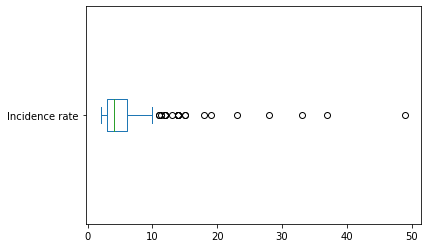

In [33]:
doctors_df["Incidence rate"].plot(kind = "box", vert = False)

0


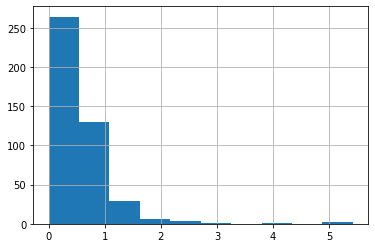

In [42]:
#Check experience column

doctors_df["Experience"].hist()

print((doctors_df["Experience"] < 0).sum())

In [47]:
doctors_df["Experience"].describe()

count    437.000000
mean       0.534027
std        0.603494
min        0.000000
25%        0.140000
50%        0.380000
75%        0.750000
max        5.420000
Name: Experience, dtype: float64

<AxesSubplot:>

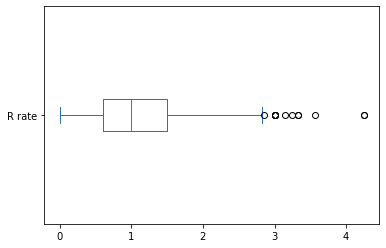

In [35]:
doctors_df["R rate"].plot(kind = "box", vert = False)

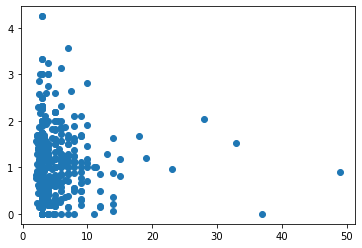

In [36]:
plt.scatter(doctors_df["Incidence rate"], doctors_df["R rate"]);

In [39]:
doctors_df["Incidence rate"].corr(doctors_df["R rate"])

-0.0422224826866023

In [50]:
doctors_df["Purchases"].value_counts().head()

4    72
3    56
5    41
7    32
8    32
Name: Purchases, dtype: int64

In [51]:
doctors_df["Purchases"].describe()

count    437.000000
mean      10.791762
std       11.429686
min        3.000000
25%        4.000000
50%        7.000000
75%       13.000000
max      129.000000
Name: Purchases, dtype: float64

In [89]:
orders_df.head(2)

,DoctorID,OrderID,OrderNum,Condition A,Condition B,Condition C,Condition D,Condition F,Condition G,Condition H,Condition I,Condition J
0,ABJEAI,DGEJFDC,AIBEHCJ,False,False,False,False,False,True,True,False,Before
1,HBIEA,DGAJDAH,AIJIHGB,False,True,NaN,False,False,True,False,True,Before


In [91]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   DoctorID     257 non-null    object
 1   OrderID      257 non-null    object
 2   OrderNum     257 non-null    object
 3   Condition A  257 non-null    bool  
 4   Condition B  257 non-null    bool  
 5   Condition C  248 non-null    object
 6   Condition D  257 non-null    bool  
 7   Condition F  254 non-null    object
 8   Condition G  254 non-null    object
 9   Condition H  257 non-null    bool  
 10  Condition I  257 non-null    bool  
 11  Condition J  149 non-null    object
dtypes: bool(5), object(7)
memory usage: 15.4+ KB


In [90]:
orders_df.isnull().sum()

DoctorID         0
OrderID          0
OrderNum         0
Condition A      0
Condition B      0
Condition C      9
Condition D      0
Condition F      3
Condition G      3
Condition H      0
Condition I      0
Condition J    108
dtype: int64

In [93]:
#Inspecting columns for condition c

orders_df["Condition C"].unique()

array([False, nan, True], dtype=object)

In [94]:
orders_df["Condition F"].unique()

array([False, nan, True], dtype=object)

In [95]:
orders_df["Condition G"].unique()

array([True, False, nan], dtype=object)

In [96]:
orders_df["Condition J"].unique()

array(['Before', nan, 'After'], dtype=object)

In [101]:
#Checking the complaints table

In [102]:
complaints_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   DoctorID        435 non-null    object
 1   Complaint Type  433 non-null    object
 2   Qty             435 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 10.3+ KB


In [105]:
complaints_df["Complaint Type"].value_counts()

Correct      205
Incorrect    118
Unknown      103
Specific       6
R&R            1
Name: Complaint Type, dtype: int64

In [111]:
complaints_df.DoctorID.nunique()

284

In [114]:
#Instructions Df

instructions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   DoctorID      77 non-null     object
 1   Instructions  77 non-null     object
dtypes: object(2)
memory usage: 1.3+ KB


In [115]:
instructions_df["Instructions"].unique()

array(['Yes', 'No'], dtype=object)

### Assessments
#### Doctors_df
- Missing values in Rank
- Satisfaction contains dashes as missing values and should be marked as float
- Category type of Rank should be ordered
- Outlier of Incidence Rate greater than 40
- Outlier of R rate greater than 4

#### Orders_df
- Missing values in condition C
- Missing values in Condition F
- Missing values in Condition G
- Missing values in Condition J

#### Complaints df
- Missing values in complaints type columns.

### Cleaning

In [61]:
#create copy of dataframe for keep

doctors_df_copy = doctors_df.copy()

In [52]:
doctors_df["Rank"].value_counts()

Ambassador       115
Platinum          77
Titanium          69
Platinum Plus     54
Gold Plus         50
Silver Plus       44
Gold              22
Silver             3
Titanium Plus      1
Name: Rank, dtype: int64

In [75]:
doctors_df["Purchases"].groupby(doctors_df["Rank"]).quantile(0.5).sort_values(ascending = False)

Rank
Ambassador       16.0
Titanium Plus    14.0
Titanium         10.0
Platinum Plus     8.0
Silver            7.0
Gold Plus         5.0
Platinum          5.0
Gold              4.0
Silver Plus       4.0
Name: Purchases, dtype: float64

From the above ordering we can spot that the number of purchases relates well with the Rank a person is, we will use this fill the missing values of the Rank column.

In [62]:
doctors_df[doctors_df["Rank"].isnull()]

,DoctorID,Region,Category,Rank,Incidence rate,R rate,Satisfaction,Experience,Purchases
110,BBAHCA,5 18,Specialist,NaN,6.0,3.14,--,1.43,7
217,AHABIB,5 18,General Practitioner,NaN,4.0,1.00,83.33,2.00,4


#### Define

- Fill missing values in index 110 with silver and fill with Silver and index 217 as Silver plus

#### Code

In [79]:
doctors_df.loc[110, "Rank"] = "Silver"
doctors_df.loc[217, "Rank"] = "Silver Plus"

#### Test

In [81]:
doctors_df.loc[[110, 217], :]

,DoctorID,Region,Category,Rank,Incidence rate,R rate,Satisfaction,Experience,Purchases
110,BBAHCA,5 18,Specialist,Silver,6.0,3.14,--,1.43,7
217,AHABIB,5 18,General Practitioner,Silver Plus,4.0,1.00,83.33,2.00,4


Satisfaction contains dashes as missing values and should be marked as float

In [85]:
(doctors_df["Satisfaction"] == "--").sum()/len(doctors_df)

0.4279176201372998

#### Define

> With up to 43% of the values in the columns missing, it would be preferred that the satisfaction column be dropped.

#### Code

In [87]:
doctors_df.drop(columns = "Satisfaction", inplace = True)

#### Test

In [88]:
"Satisfaction" in doctors_df.columns

False

##### Category type of Rank should be ordered

In [141]:
doctors_df["Rank"].unique()

#Ambassadors, followed by Titanium Plus, 
#Titanium, Platinum Plus, Platinum, Gold Plus, Gold, Silver Plus, and the lowest level is Silver.

array(['Ambassador', 'Platinum Plus', 'Titanium', 'Silver Plus', 'Gold',
       'Platinum', 'Gold Plus', 'Silver', 'Titanium Plus'], dtype=object)

In [149]:
len(doctors_df["Rank"])

437

In [153]:
ordered_list = ["Silver", "Silver Plus", "Gold", "Gold Plus", 
                "Platinum", "Platinum Plus", "Titanium",
               "Titanium Plus", "Ambassador"]

rank_type = pd.CategoricalDtype(ordered_list, ordered = True)
rank_type

doctors_df["Rank"] = doctors_df["Rank"].astype(rank_type)

In [154]:
doctors_df["Rank"].unique()

['Ambassador', 'Platinum Plus', 'Titanium', 'Silver Plus', 'Gold', 'Platinum', 'Gold Plus', 'Silver', 'Titanium Plus']
Categories (9, object): ['Silver' < 'Silver Plus' < 'Gold' < 'Gold Plus' ... 'Platinum Plus' < 'Titanium' < 'Titanium Plus' < 'Ambassador']

### Orders_df cleaning

#### Define
- Orders df - condition C, F, G, missing values to be droppedCondition Ce
- Condition j column to dropped

#### Code

In [117]:
orders_df.shape

(257, 12)

In [118]:
col_drop = ["Condition C", "Condition F", "Condition G"]

for col in col_drop:
    orders_df = orders_df[~orders_df[col].isnull()]

In [121]:
orders_df.drop(columns = "Condition J", inplace = True)

In [123]:
for col in col_drop:
    orders_df[col] = orders_df[col].astype(bool)

#### Test

In [122]:
orders_df.shape

(248, 11)

In [124]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 248 entries, 0 to 256
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   DoctorID     248 non-null    object
 1   OrderID      248 non-null    object
 2   OrderNum     248 non-null    object
 3   Condition A  248 non-null    bool  
 4   Condition B  248 non-null    bool  
 5   Condition C  248 non-null    bool  
 6   Condition D  248 non-null    bool  
 7   Condition F  248 non-null    bool  
 8   Condition G  248 non-null    bool  
 9   Condition H  248 non-null    bool  
 10  Condition I  248 non-null    bool  
dtypes: bool(8), object(3)
memory usage: 9.7+ KB


#### Define

- Rename missing values in the Compaints Type column in complaints_df to Unknown

#### Code

In [128]:
complaints_df["Complaint Type"].replace({np.nan: "Unknown"}, inplace=True)

#### Test

In [129]:
complaints_df["Complaint Type"].unique()

array(['Correct', 'Unknown', 'Incorrect', 'Specific', 'R&R'], dtype=object)

### Exploratory Data Analysis

In [137]:
doctors_df.head(1)

,DoctorID,Region,Category,Rank,Incidence rate,R rate,Experience,Purchases
0,AHDCBA,4 15,Specialist,Ambassador,49.0,0.9,1.2,49


In [133]:
doctors_df.describe(include = "object")

,DoctorID,Region,Category,Rank
count,437,437,437,437
unique,437,46,2,9
top,AHDCBA,1 13,Specialist,Ambassador
freq,1,34,367,115


In [134]:
orders_df.head(1)

,DoctorID,OrderID,OrderNum,Condition A,Condition B,Condition C,Condition D,Condition F,Condition G,Condition H,Condition I
0,ABJEAI,DGEJFDC,AIBEHCJ,False,False,False,False,False,True,True,False


In [135]:
complaints_df.head(1)

,DoctorID,Complaint Type,Qty
0,EHAHI,Correct,10


In [136]:
instructions_df.head(1)

,DoctorID,Instructions
0,ADIFBD,Yes


### Questions

- How many doctors are there in each region? What is the average number of purchases per region?
- Can you find a relationship between purchases and complaints?
- Define new doctor segments that help the company improve marketing efforts and customer service.
- Identify which features impact the new segmentation strategy the most.
- Your team will need to explain the new segments to the rest of the company. 
- Describe which characteristics distinguish the newly defined segments.

#### How many doctors are there in each region? What is the average number of purchases per region?

In [199]:
#Let us seperate the dataframe between the Specialist and General types of doctors, if there is difference

specialist_df = doctors_df[doctors_df["Category"] == "Specialist"]
general_df = doctors_df[doctors_df["Category"] == "General Practitioner"]

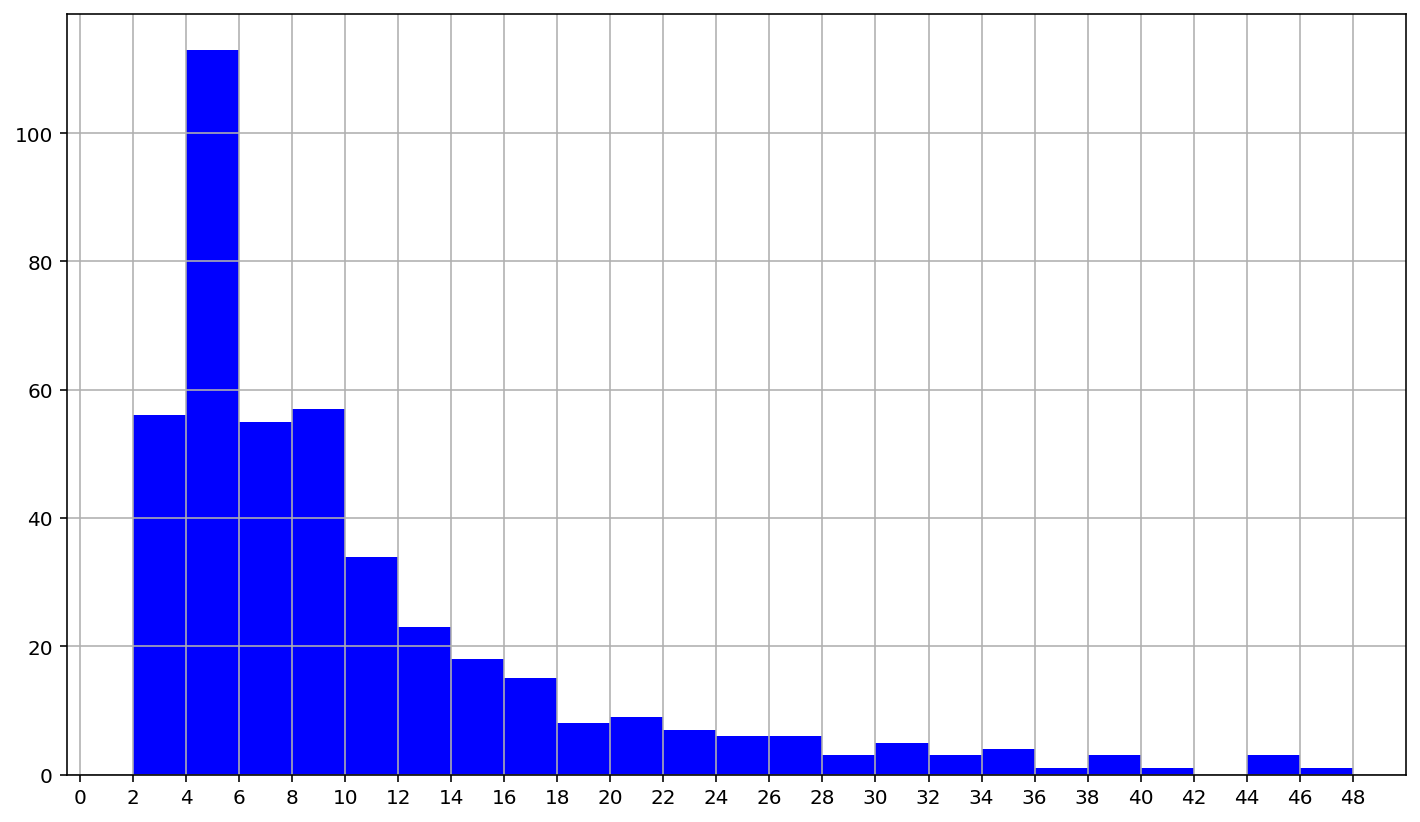

In [325]:
#Check the distribution of purchase of the different category
#bins = np.arange(0, 125, 5)
bins = np.arange(0, 50, 2)
doctors_df["Purchases"].hist(bins = bins, figsize=[12,7], color = "b")
plt.xlim(-0.5, 50)
plt.xticks(bins, bins);

**Observation**

- The Histogram is a right skewed histogram which shows that many extreme are to the right with the mode of the data being between purchases 4 to 6.

#### What is the distribution of Categories in the data

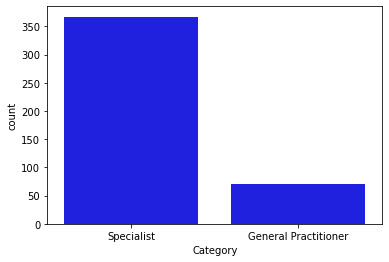

In [221]:
sns.countplot(data=doctors_df, 
             x = "Category", color="b");

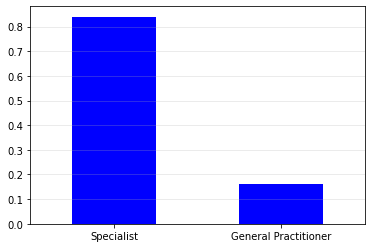

In [232]:
doctors_df["Category"].value_counts(normalize = True).plot(kind = "bar", color = "b")
plt.xticks(rotation = 0)
plt.grid(axis = "y", alpha = 0.3);

**Observation:**

- There are definitely more Specialist than General Practictioners. With about more than 80% being specialist.

In [156]:
doctors_df.columns

Index(['DoctorID', 'Region', 'Category', 'Rank', 'Incidence rate', 'R rate',
       'Experience', 'Purchases'],
      dtype='object')

In [180]:
#Using the groupby to group doctor counts and the average purchase by region

region_gb = (doctors_df.groupby("Region")["Purchases"].aggregate(["mean", "count"])
 .rename(columns = {"mean": "Average Purchase", "count": "Number of doctors"}))

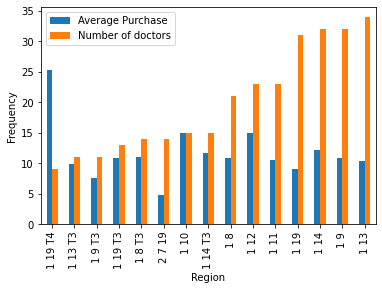

In [233]:
region_gb.sort_values("Number of doctors", ascending = True).tail(15).plot(kind = "bar")
plt.ylabel("Frequency");

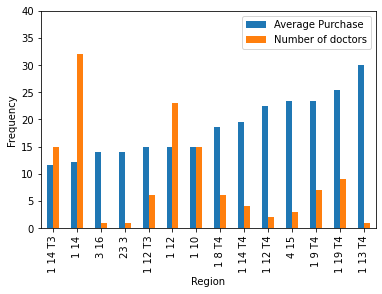

In [234]:
region_gb.sort_values("Average Purchase", ascending = True).tail(15).plot(kind = "bar")
plt.xlim(-0.5, 13.5)
plt.ylim(0, 40)
plt.ylabel("Frequency");

**Observation:**
- From the plots above, although we expected that as the number of doctors increased, the average number of devices ordered would increase, but these plots do not appear a pattern of such.

#### The realtionship between purchases of specialist and doctors

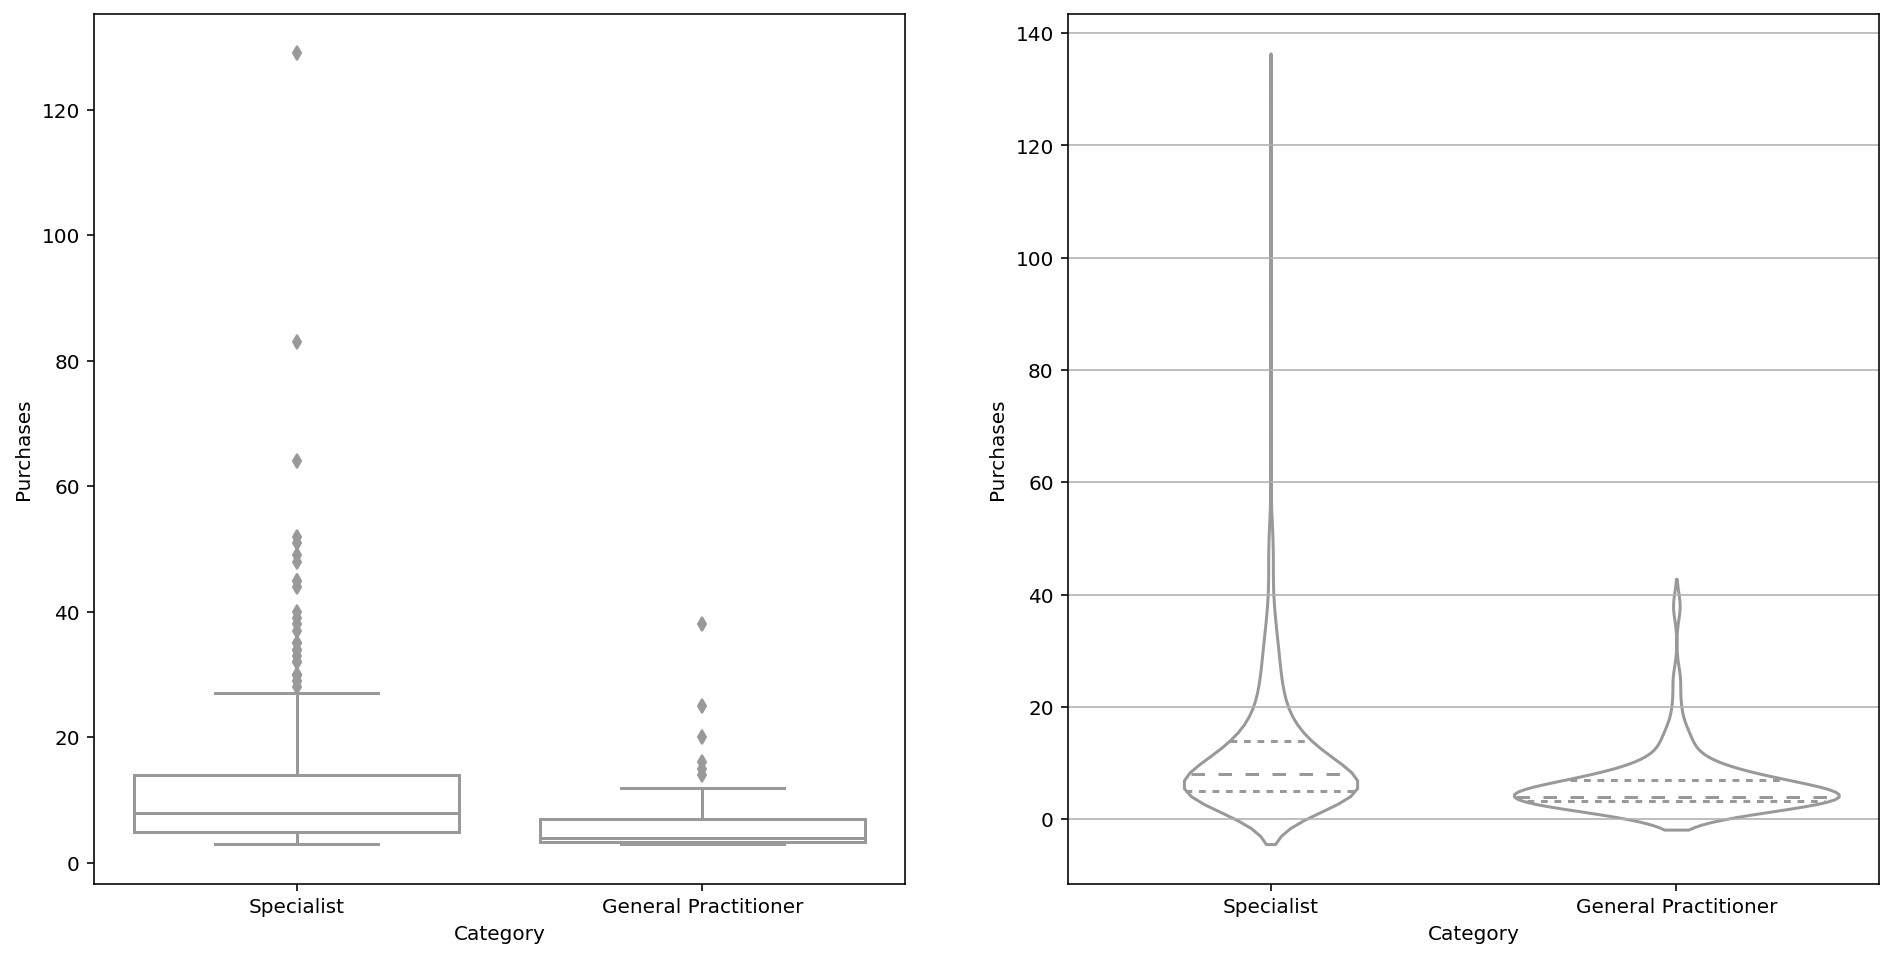

In [253]:
plt.figure(figsize = [16, 8])

plt.subplot(1, 2, 1)
sns.boxplot(x = doctors_df["Category"],
           y = doctors_df["Purchases"],
           color="white")

plt.subplot(1, 2, 2)
sns.violinplot(x = doctors_df["Category"],
           y = doctors_df["Purchases"], 
              color = "white", inner = "quartile")
plt.grid(axis = "y");

In [255]:
print(specialist_df["Purchases"].median())
print(general_df["Purchases"].median())

8.0
4.0


**Observation**

- From the above, we see that there is a slight difference between the purchases made by Specialist and General Practicitioner.
- With a median of 4.0 for general practitioners and 8.0 for specialist.
- Also we see that most/mode purchases of general practictioners are so close to their median as 4.0 also
- But we see that specialist have a median higher than their mode and higher than 4.0 with a greater spread than general practictioners which we expect given the number of specialist that we have in the dataset when compared with the general practictioners.

#### Relationship between Complaints and Number of purchases

In [257]:
complaints_df.head(1)

,DoctorID,Complaint Type,Qty
0,EHAHI,Correct,10


In [258]:
doctors_df.head(1)

,DoctorID,Region,Category,Rank,Incidence rate,R rate,Experience,Purchases
0,AHDCBA,4 15,Specialist,Ambassador,49.0,0.9,1.2,49


In [289]:
#merge both table together

complaint_pur = pd.merge(complaints_df, doctors_df, how = "inner", on = "DoctorID")

In [296]:
complaint_pur.head()

,DoctorID,Complaint Type,Qty,Region,Category,Rank,Incidence rate,R rate,Experience,Purchases
0,EHEGI,Correct,1,1 8,Specialist,Platinum,3.00,1.50,0.25,4
1,EHEGI,Unknown,1,1 8,Specialist,Platinum,3.00,1.50,0.25,4
2,EHHGF,Correct,1,1 12 T3,Specialist,Titanium,2.50,1.86,0.57,7
3,EIFEJ,Correct,2,1 9 T4,Specialist,Ambassador,2.86,0.81,0.00,27
4,EIFEJ,Unknown,1,1 9 T4,Specialist,Ambassador,2.86,0.81,0.00,27


In [368]:
complaint_group_add = complaint_pur.groupby("DoctorID")[["Qty", "Purchases"]].sum()

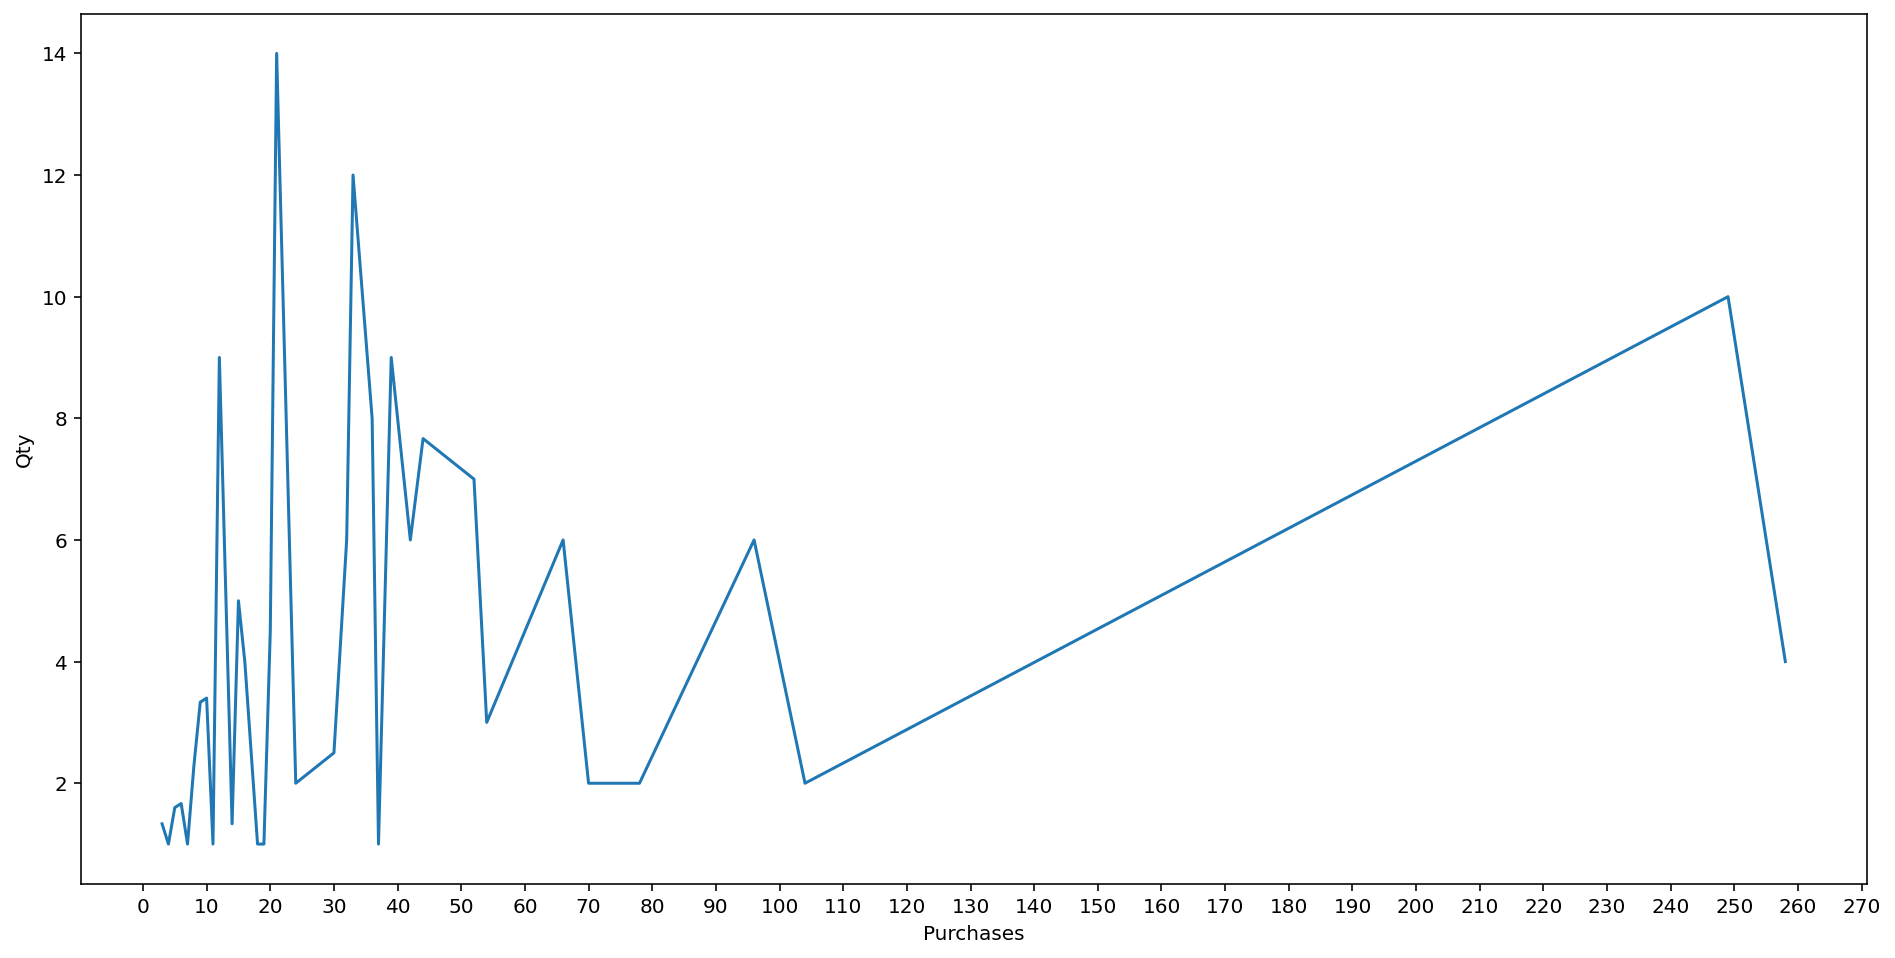

In [356]:
plt.figure(figsize = [16, 8])
sns.lineplot(x = complaint_group_add["Purchases"],
            y = complaint_group_add["Qty"], ci = None)
xticks = np.arange(0, 280, 10)
plt.xticks(xticks, xticks);

In [300]:
px.line(data_frame=complaint_pur,
       x = "Purchases", y = "Qty", color="Region")

**Observation**
- From the plots above, it is really hard and inconvinient to be able to pick out a trend or pattern that exists between the quantity of complaints and the amount of services purchases.
- However we see that purchases made between 0 - 30 purchases resulted into some spikes in the number of complaints received and followed an increasing in the complaints with increasing purchases but this effect wears off as soon as the purchases made are above 30. 
- It follows sort of like a normal distribution where the number of complaints lodged is not about how much of the purchase made but a a normal distribution.

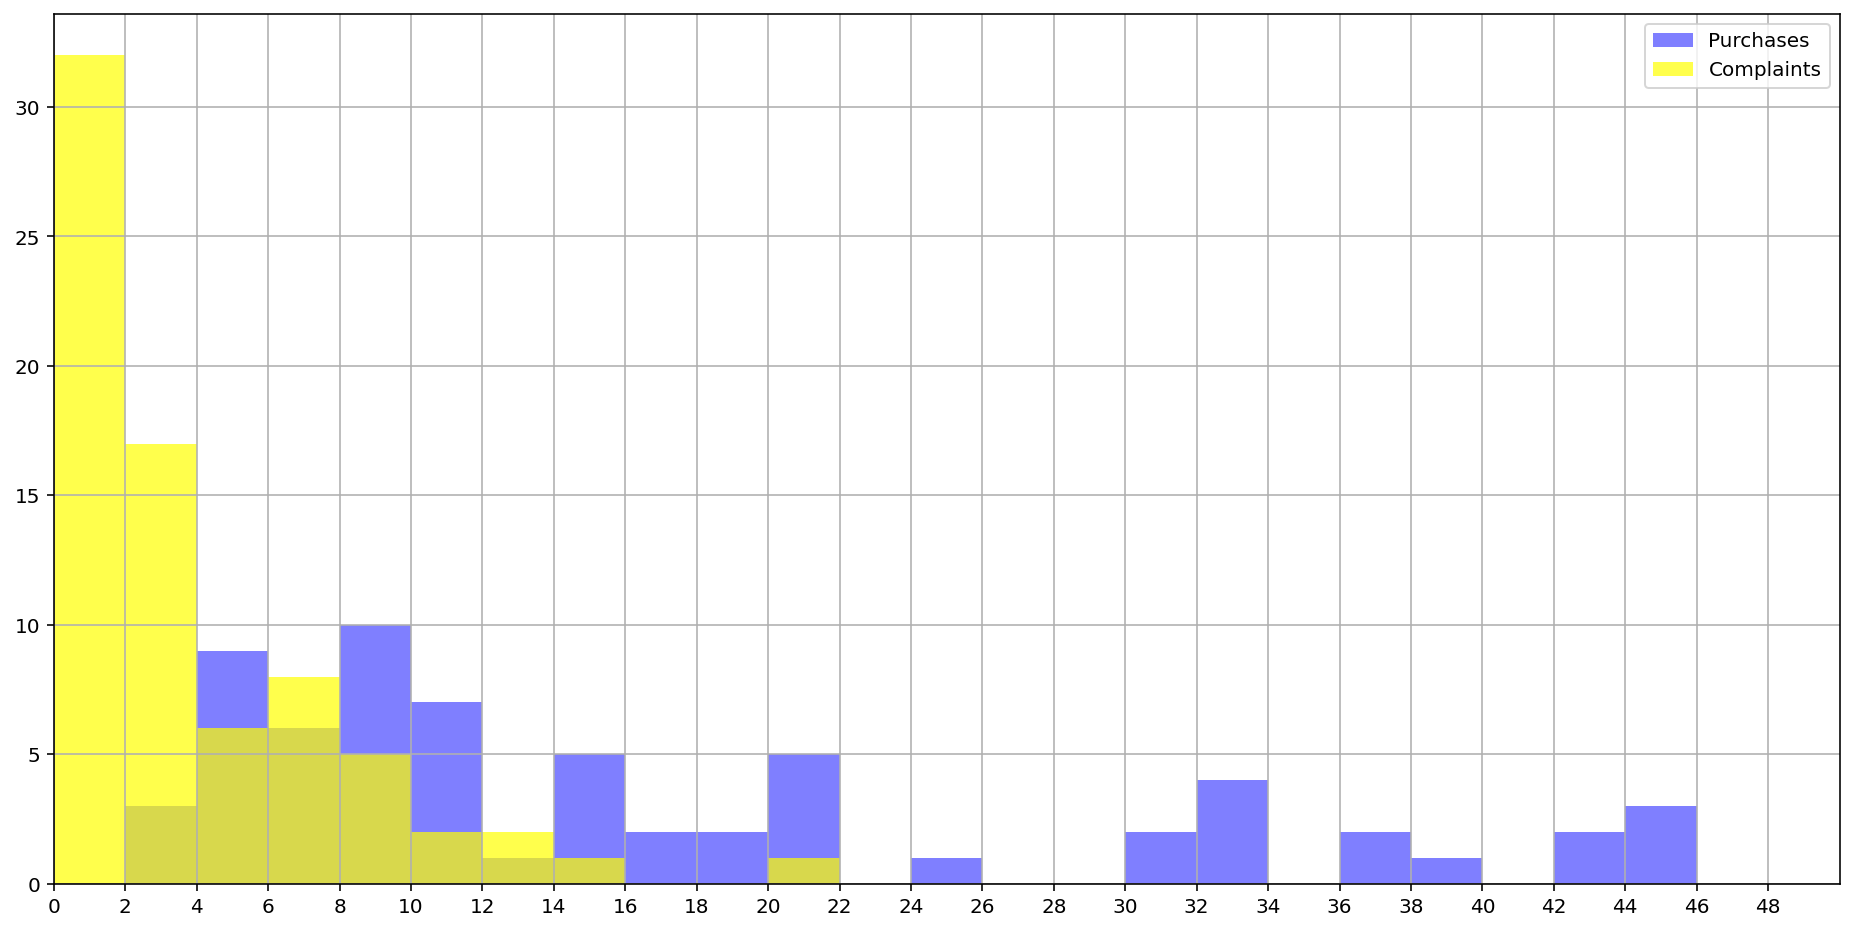

In [352]:
plt.figure(figsize = [16, 8])
bins = np.arange(0, 50, 2)
complaint_group_add["Purchases"].hist(bins = bins, alpha = 0.5, color = "blue")
complaint_group_add["Qty"].hist(bins = bins, alpha = 0.7, color = "yellow")
plt.xticks(bins, bins)
plt.xlim(0, 50)
plt.legend(["Purchases", "Complaints"]);

### Using kprototype for clustering

In [302]:
doctors_df.head(1)

,DoctorID,Region,Category,Rank,Incidence rate,R rate,Experience,Purchases
0,AHDCBA,4 15,Specialist,Ambassador,49.0,0.9,1.2,49


In [369]:
orders_df.head(1)

,DoctorID,OrderID,OrderNum,Condition A,Condition B,Condition C,Condition D,Condition F,Condition G,Condition H,Condition I
0,ABJEAI,DGEJFDC,AIBEHCJ,False,False,False,False,False,True,True,False


In [373]:
complaints_df.head()

,DoctorID,Complaint Type,Qty
0,EHAHI,Correct,10
1,EHDGF,Correct,2
2,EHDGF,Unknown,3
3,EHDIJ,Correct,8
4,EHDIJ,Incorrect,2


In [382]:
#combining the doctor_df and complains_df table

doctors_merge = pd.merge(complaints_df, doctors_df, how = "right", on = "DoctorID")
doctors_merge.sample()

,DoctorID,Complaint Type,Qty,Region,Category,Rank,Incidence rate,R rate,Experience,Purchases
43,ACIEJG,NaN,NaN,2 6 13,General Practitioner,Gold Plus,9.0,0.33,0.22,9


In [388]:
#Fill missing values from the merged dataframe as the following
#Complaint type as no complaint
#And Qty as 0

doctors_merge["Complaint Type"].fillna("No Complaints", inplace = True)
doctors_merge["Qty"].fillna(0, inplace = True)

In [390]:
#Test
doctors_merge.isna().sum()

DoctorID          0
Complaint Type    0
Qty               0
Region            0
Category          0
Rank              0
Incidence rate    0
R rate            0
Experience        0
Purchases         0
dtype: int64

#### Split the dataframe for use into the kprototype model

In [415]:
doctors_merge.head()

,DoctorID,Complaint Type,Qty,Region,Category,Rank,Incidence rate,R rate,Experience,Purchases
0,AHDCBA,No Complaints,0.0,4 15,Specialist,Ambassador,49.0,0.90,1.20,49
1,ABHAHF,No Complaints,0.0,1 8 T4,General Practitioner,Ambassador,37.0,0.00,0.00,38
2,FDHFJ,No Complaints,0.0,1 9 T4,Specialist,Ambassador,33.0,1.53,0.00,34
3,BJJHCA,No Complaints,0.0,1 10 T3,Specialist,Ambassador,28.0,2.03,0.48,29
4,FJBEA,No Complaints,0.0,1 14 T4,Specialist,Ambassador,23.0,0.96,0.75,24


In [417]:
#Drop DoctorID

X = doctors_merge.drop(columns = ["DoctorID"])
X.head()

,Complaint Type,Qty,Region,Category,Rank,Incidence rate,R rate,Experience,Purchases
0,No Complaints,0.0,4 15,Specialist,Ambassador,49.0,0.90,1.20,49
1,No Complaints,0.0,1 8 T4,General Practitioner,Ambassador,37.0,0.00,0.00,38
2,No Complaints,0.0,1 9 T4,Specialist,Ambassador,33.0,1.53,0.00,34
3,No Complaints,0.0,1 10 T3,Specialist,Ambassador,28.0,2.03,0.48,29
4,No Complaints,0.0,1 14 T4,Specialist,Ambassador,23.0,0.96,0.75,24


In [418]:
#scale all numerical values present

num_trans = StandardScaler().fit_transform(X[["Qty", "Incidence rate", "Experience", "R rate", "Experience", "Purchases"]])
X[["Qty", "Incidence rate", "Experience", "R rate", "Experience", "Purchases"]] = num_trans

In [419]:
#Convert dataframe into numpy array which is acceptable for kprototype

X = X.values
X

array([['No Complaints', -0.4043038799170635, '4 15', ...,
        -0.29716033023596766, 1.137681632515821, 2.7969511931253797],
       ['No Complaints', -0.4043038799170635, '1 8 T4', ...,
        -1.5289943749706258, -0.9207326417264851, 1.9756145407896555],
       ['No Complaints', -0.4043038799170635, '1 9 T4', ...,
        0.5651235010782931, -0.9207326417264851, 1.6769466672130284],
       ...,
       ['No Complaints', -0.4043038799170635, '1 19 T4', ...,
        -0.47509191447541826, -0.4575894300219661, 0.7809430464831475],
       ['No Complaints', -0.4043038799170635, '1 9', ...,
        -0.37928259988494495, -0.37182216859520334, 1.0049439516656178],
       ['No Complaints', -0.4043038799170635, '1 13', ...,
        0.6061846359027818, -0.2517480025977355, 3.9169557190377304]],
      dtype=object)

In [420]:
#Convert the numerical columns to float

X[:, 1] = X[:, 1].astype(float)
X[:, 5] = X[:, 5].astype(float)
X[:, 6] = X[:, 6].astype(float)
X[:, 7] = X[:, 7].astype(float)
X[:, 8] = X[:, 8].astype(float)

In [421]:
#Create list for categorical index

cat_index = [0, 2, 3, 4]

In [428]:
#Plot the elbow curve after fitting the data to choose the eventual number of clusters

no_clusters = range(1, 18)
error_metrics = []

for k in no_clusters:
    
    #Instantiate model
    test_model = KPrototypes(n_clusters = k, init="Huang", random_state=42, verbose=1)
    #Use mdoel to fit predict clusters
    test_model.fit_predict(X, categorical = cat_index)
    #Append error to the list
    error_metrics.append(test_model.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 0, ncost: 2939.499999999997
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 0, ncost: 2939.499999999997
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 0, ncost: 2939.499999999997
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 0, ncost: 2939.499999999997
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 5, iteration: 1/100, moves: 0, ncost: 2939.499999999997
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 6, iteration: 1/100, moves: 0, ncost: 2939.499999999997
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 7, iteration: 1/100, moves: 0, ncost: 2939.499999999997
Init: initial

Run: 3, iteration: 1/100, moves: 48, ncost: 2335.5513468609606
Run: 3, iteration: 2/100, moves: 20, ncost: 2325.4751087701275
Run: 3, iteration: 3/100, moves: 10, ncost: 2320.277090203953
Run: 3, iteration: 4/100, moves: 12, ncost: 2311.786415284419
Run: 3, iteration: 5/100, moves: 11, ncost: 2298.191686909347
Run: 3, iteration: 6/100, moves: 6, ncost: 2293.1662945026524
Run: 3, iteration: 7/100, moves: 2, ncost: 2292.3456618932273
Run: 3, iteration: 8/100, moves: 0, ncost: 2292.3456618932273
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 84, ncost: 2275.600549691589
Run: 4, iteration: 2/100, moves: 38, ncost: 2256.0494230246622
Run: 4, iteration: 3/100, moves: 9, ncost: 2254.7899882904994
Run: 4, iteration: 4/100, moves: 1, ncost: 2254.6166057984683
Run: 4, iteration: 5/100, moves: 0, ncost: 2254.6166057984683
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 5, iteration: 1/100, moves

Run: 6, iteration: 4/100, moves: 31, ncost: 1987.5255370920734
Run: 6, iteration: 5/100, moves: 15, ncost: 1985.328182416355
Run: 6, iteration: 6/100, moves: 6, ncost: 1984.4691603052088
Run: 6, iteration: 7/100, moves: 1, ncost: 1984.4002526375593
Run: 6, iteration: 8/100, moves: 2, ncost: 1984.311080288278
Run: 6, iteration: 9/100, moves: 0, ncost: 1984.311080288278
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 7, iteration: 1/100, moves: 92, ncost: 2139.8404257756692
Run: 7, iteration: 2/100, moves: 47, ncost: 2120.0326237201575
Run: 7, iteration: 3/100, moves: 36, ncost: 2109.308088598652
Run: 7, iteration: 4/100, moves: 24, ncost: 2103.113757484744
Run: 7, iteration: 5/100, moves: 22, ncost: 2085.2448843343223
Run: 7, iteration: 6/100, moves: 25, ncost: 2066.957930656494
Run: 7, iteration: 7/100, moves: 15, ncost: 2060.9707468514093
Run: 7, iteration: 8/100, moves: 5, ncost: 2060.236177224465
Run: 7, iteration: 9/100, moves: 1, ncost: 2060.21

Run: 8, iteration: 7/100, moves: 17, ncost: 1852.1894371796302
Run: 8, iteration: 8/100, moves: 21, ncost: 1842.9904015545474
Run: 8, iteration: 9/100, moves: 27, ncost: 1832.3955232273631
Run: 8, iteration: 10/100, moves: 21, ncost: 1818.3002732474283
Run: 8, iteration: 11/100, moves: 24, ncost: 1797.1003686433976
Run: 8, iteration: 12/100, moves: 35, ncost: 1782.6746482491913
Run: 8, iteration: 13/100, moves: 14, ncost: 1780.1224075884586
Run: 8, iteration: 14/100, moves: 5, ncost: 1778.762292749099
Run: 8, iteration: 15/100, moves: 1, ncost: 1778.7241209300755
Run: 8, iteration: 16/100, moves: 0, ncost: 1778.7241209300755
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 9, iteration: 1/100, moves: 121, ncost: 1974.91197448563
Run: 9, iteration: 2/100, moves: 61, ncost: 1925.3578807492086
Run: 9, iteration: 3/100, moves: 35, ncost: 1903.444638590897
Run: 9, iteration: 4/100, moves: 17, ncost: 1882.7525161276399
Run: 9, iteration: 5/100, moves: 7, n

Run: 8, iteration: 3/100, moves: 55, ncost: 1649.5787913843571
Run: 8, iteration: 4/100, moves: 44, ncost: 1620.5988498239806
Run: 8, iteration: 5/100, moves: 23, ncost: 1613.0350890876132
Run: 8, iteration: 6/100, moves: 11, ncost: 1604.3201848101164
Run: 8, iteration: 7/100, moves: 2, ncost: 1603.2127070582412
Run: 8, iteration: 8/100, moves: 4, ncost: 1598.8714367017697
Run: 8, iteration: 9/100, moves: 0, ncost: 1598.8714367017697
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 9, iteration: 1/100, moves: 281, ncost: 1753.4019605117653
Run: 9, iteration: 2/100, moves: 86, ncost: 1692.2122962505973
Run: 9, iteration: 3/100, moves: 53, ncost: 1638.4672079787154
Run: 9, iteration: 4/100, moves: 39, ncost: 1602.1310843772935
Run: 9, iteration: 5/100, moves: 13, ncost: 1593.8878335302188
Run: 9, iteration: 6/100, moves: 13, ncost: 1583.7202481646768
Run: 9, iteration: 7/100, moves: 6, ncost: 1581.3741059987713
Run: 9, iteration: 8/100, moves: 5, ncost

Run: 10, iteration: 1/100, moves: 216, ncost: 1612.8743062457163
Run: 10, iteration: 2/100, moves: 60, ncost: 1564.14373813299
Run: 10, iteration: 3/100, moves: 27, ncost: 1549.286555680646
Run: 10, iteration: 4/100, moves: 18, ncost: 1538.7693310516092
Run: 10, iteration: 5/100, moves: 14, ncost: 1533.659812425838
Run: 10, iteration: 6/100, moves: 16, ncost: 1527.7765883700904
Run: 10, iteration: 7/100, moves: 12, ncost: 1526.297113154077
Run: 10, iteration: 8/100, moves: 3, ncost: 1526.1416762125682
Run: 10, iteration: 9/100, moves: 1, ncost: 1526.1132771599025
Run: 10, iteration: 10/100, moves: 0, ncost: 1526.1132771599025
Best run was number 9
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 158, ncost: 1571.5814090771112
Run: 1, iteration: 2/100, moves: 59, ncost: 1496.0715037150703
Run: 1, iteration: 3/100, moves: 45, ncost: 1465.514835102363
Run: 1, iteration: 4/100, moves: 50, ncost: 1436.1406155906857
Run: 1, iter

Run: 2, iteration: 3/100, moves: 46, ncost: 1318.941667596508
Run: 2, iteration: 4/100, moves: 29, ncost: 1309.9130327693558
Run: 2, iteration: 5/100, moves: 26, ncost: 1300.065939794513
Run: 2, iteration: 6/100, moves: 13, ncost: 1296.686418172225
Run: 2, iteration: 7/100, moves: 2, ncost: 1296.0070644181271
Run: 2, iteration: 8/100, moves: 16, ncost: 1292.915488845518
Run: 2, iteration: 9/100, moves: 13, ncost: 1291.1153121705154
Run: 2, iteration: 10/100, moves: 11, ncost: 1289.8894320002662
Run: 2, iteration: 11/100, moves: 2, ncost: 1289.834775412043
Run: 2, iteration: 12/100, moves: 0, ncost: 1289.834775412043
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 150, ncost: 1411.2143108896425
Run: 3, iteration: 2/100, moves: 49, ncost: 1373.1610265549566
Run: 3, iteration: 3/100, moves: 33, ncost: 1353.5571424966226
Run: 3, iteration: 4/100, moves: 51, ncost: 1325.

Run: 2, iteration: 11/100, moves: 0, ncost: 1241.5723199007725
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 181, ncost: 1522.599011422723
Run: 3, iteration: 2/100, moves: 116, ncost: 1380.776898566965
Run: 3, iteration: 3/100, moves: 50, ncost: 1353.058179035234
Run: 3, iteration: 4/100, moves: 9, ncost: 1349.5878768098337
Run: 3, iteration: 5/100, moves: 7, ncost: 1348.830979024955
Run: 3, iteration: 6/100, moves: 1, ncost: 1348.7964207093783
Run: 3, iteration: 7/100, moves: 0, ncost: 1348.7964207093783
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 100, ncost: 1435.0836431126838
Run: 4, iteration: 2/100, moves: 77, ncost: 1324.4078908173062
Run: 4, iteration: 3/100, moves: 43, ncost: 1294.1033961269673
Run: 4, iteration: 4/100, moves: 33, n

Run: 5, iteration: 8/100, moves: 1, ncost: 1155.944160618069
Run: 5, iteration: 9/100, moves: 0, ncost: 1155.944160618069
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 6, iteration: 1/100, moves: 220, ncost: 1395.181644071218
Run: 6, iteration: 2/100, moves: 119, ncost: 1281.3701896641617
Run: 6, iteration: 3/100, moves: 73, ncost: 1198.9325997572157
Run: 6, iteration: 4/100, moves: 35, ncost: 1169.1661110450111
Run: 6, iteration: 5/100, moves: 12, ncost: 1159.3229865770254
Run: 6, iteration: 6/100, moves: 5, ncost: 1158.9595028879794
Run: 6, iteration: 7/100, moves: 6, ncost: 1157.4377619578254
Run: 6, iteration: 8/100, moves: 6, ncost: 1156.2703321456872
Run: 6, iteration: 9/100, moves: 4, ncost: 1153.9117488977877
Run: 6, iteration: 10/100, moves: 2, ncost: 1150.7547996451228
Run: 6, iteration: 11/100, moves: 0, ncost: 1150.75479964

Run: 5, iteration: 7/100, moves: 3, ncost: 1124.3146729021996
Run: 5, iteration: 8/100, moves: 1, ncost: 1124.2946598493913
Run: 5, iteration: 9/100, moves: 0, ncost: 1124.2946598493913
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 6, iteration: 1/100, moves: 171, ncost: 1248.0729893593905
Run: 6, iteration: 2/100, moves: 84, ncost: 1191.1401870339419
Run: 6, iteration: 3/100, moves: 49, ncost: 1171.5057417673033
Run: 6, iteration: 4/100, moves: 33, ncost: 1162.0261514578344
Run: 6, iteration: 5/100, moves: 18, ncost: 1152.9945430222224
Run: 6, iteration: 6/100, moves: 18, ncost: 1137.7342650939327
Run: 6, iteration: 7/100, moves: 20, ncost: 1123.7246199658657
Run: 6, iteration: 8/100, moves: 27, ncost: 1114.4761425416327
Run: 6, iteration: 9/100, moves: 19, ncost: 1109.9497500858495
Run: 6, iteration: 10/100, moves: 13, ncost: 1108.160651032133
Run: 6, iteration: 11/100, moves: 16, ncost: 1

Run: 5, iteration: 7/100, moves: 5, ncost: 1055.0077999775253
Run: 5, iteration: 8/100, moves: 4, ncost: 1054.370994720035
Run: 5, iteration: 9/100, moves: 3, ncost: 1053.9926870183745
Run: 5, iteration: 10/100, moves: 1, ncost: 1053.9237303975972
Run: 5, iteration: 11/100, moves: 0, ncost: 1053.9237303975972
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 6, iteration: 1/100, moves: 196, ncost: 1266.0388180585496
Run: 6, iteration: 2/100, moves: 60, ncost: 1211.3303031697544
Run: 6, iteration: 3/100, moves: 35, ncost: 1158.279465557065
Run: 6, iteration: 4/100, moves: 30, ncost: 1113.14776856432
Run: 6, iteration: 5/100, moves: 29, ncost: 1079.7924428025915
Run: 6, iteration: 6/100, moves: 10, ncost: 1058.9773327109046
Run: 6, iteration: 7/100, moves: 5, ncost: 1058.1903629738492


Run: 5, iteration: 15/100, moves: 3, ncost: 1029.5937541839266
Run: 5, iteration: 16/100, moves: 1, ncost: 1029.548430145947
Run: 5, iteration: 17/100, moves: 0, ncost: 1029.548430145947
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 6, iteration: 1/100, moves: 191, ncost: 1133.9136018668578
Run: 6, iteration: 2/100, moves: 43, ncost: 1096.066079936677
Run: 6, iteration: 3/100, moves: 11, ncost: 1086.7018764486288
Run: 6, iteration: 4/100, moves: 0, ncost: 1086.7018764486288
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroi

Run: 5, iteration: 11/100, moves: 2, ncost: 1020.353183820047
Run: 5, iteration: 12/100, moves: 0, ncost: 1020.353183820047
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 6, iteration: 1/100, moves: 163, ncost: 1113.172894711503
Run: 6, iteration: 2/100, moves: 69, ncost: 1062.4828104088542
Run: 6, iteration: 3/100, moves: 20, ncost: 1038.5434379155943
Run: 6, iteration: 4/100, moves: 6, ncost: 1037.8631215850592
Run: 6, iteration: 5/100, moves: 2, ncost: 1037.6915019710975
Run: 6, iteration: 6/100, moves: 0, ncost: 1037.6915019710975
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing cen

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 5, iteration: 1/100, moves: 188, ncost: 1110.9140933245783
Run: 5, iteration: 2/100, moves: 104, ncost: 1033.555417113396
Run: 5, iteration: 3/100, moves: 37, ncost: 1018.57903037539
Run: 5, iteration: 4/100, moves: 32, ncost: 1001.9463489747883
Run: 5, iteration: 5/100, moves: 25, ncost: 994.3213486121763
Run: 5, iteration: 6/100, moves: 13, ncost: 989.5923783382151
Run: 5, iteration: 7/100, moves: 14, ncost: 986.0543173051858
Run: 5, iteration: 8/100, moves: 5, ncost: 985.357658718002
Run: 5, iteration: 9/100, moves: 4, ncost: 984.7827718207826
Run: 5, iteration: 10/100, moves: 7, ncost: 984.4397491722908
Run: 5, iteration: 11/100, moves: 1, ncost: 984.3327697331123
Run: 5, iteration: 12/100, moves: 1, ncost: 984.3178509593625
Run: 5, iteration: 13/100, moves: 0, ncost: 984.3178509593625


Run: 3, iteration: 5/100, moves: 22, ncost: 985.3419205743788
Run: 3, iteration: 6/100, moves: 16, ncost: 982.3552671757687
Run: 3, iteration: 7/100, moves: 13, ncost: 978.7410415577557
Run: 3, iteration: 8/100, moves: 7, ncost: 978.306180289268
Run: 3, iteration: 9/100, moves: 4, ncost: 977.8788110985876
Run: 3, iteration: 10/100, moves: 0, ncost: 977.8788110985876
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 189, ncost: 1024.879615251066
Run: 4, iteration: 2/100, moves: 75, ncost: 980.4427107671481
Run: 4, iteration: 3/100, moves: 29, ncost: 958.6855488832877
Run: 4, iteration: 4/100, moves: 18, ncost: 953.1215866482463
Run: 4, iteration

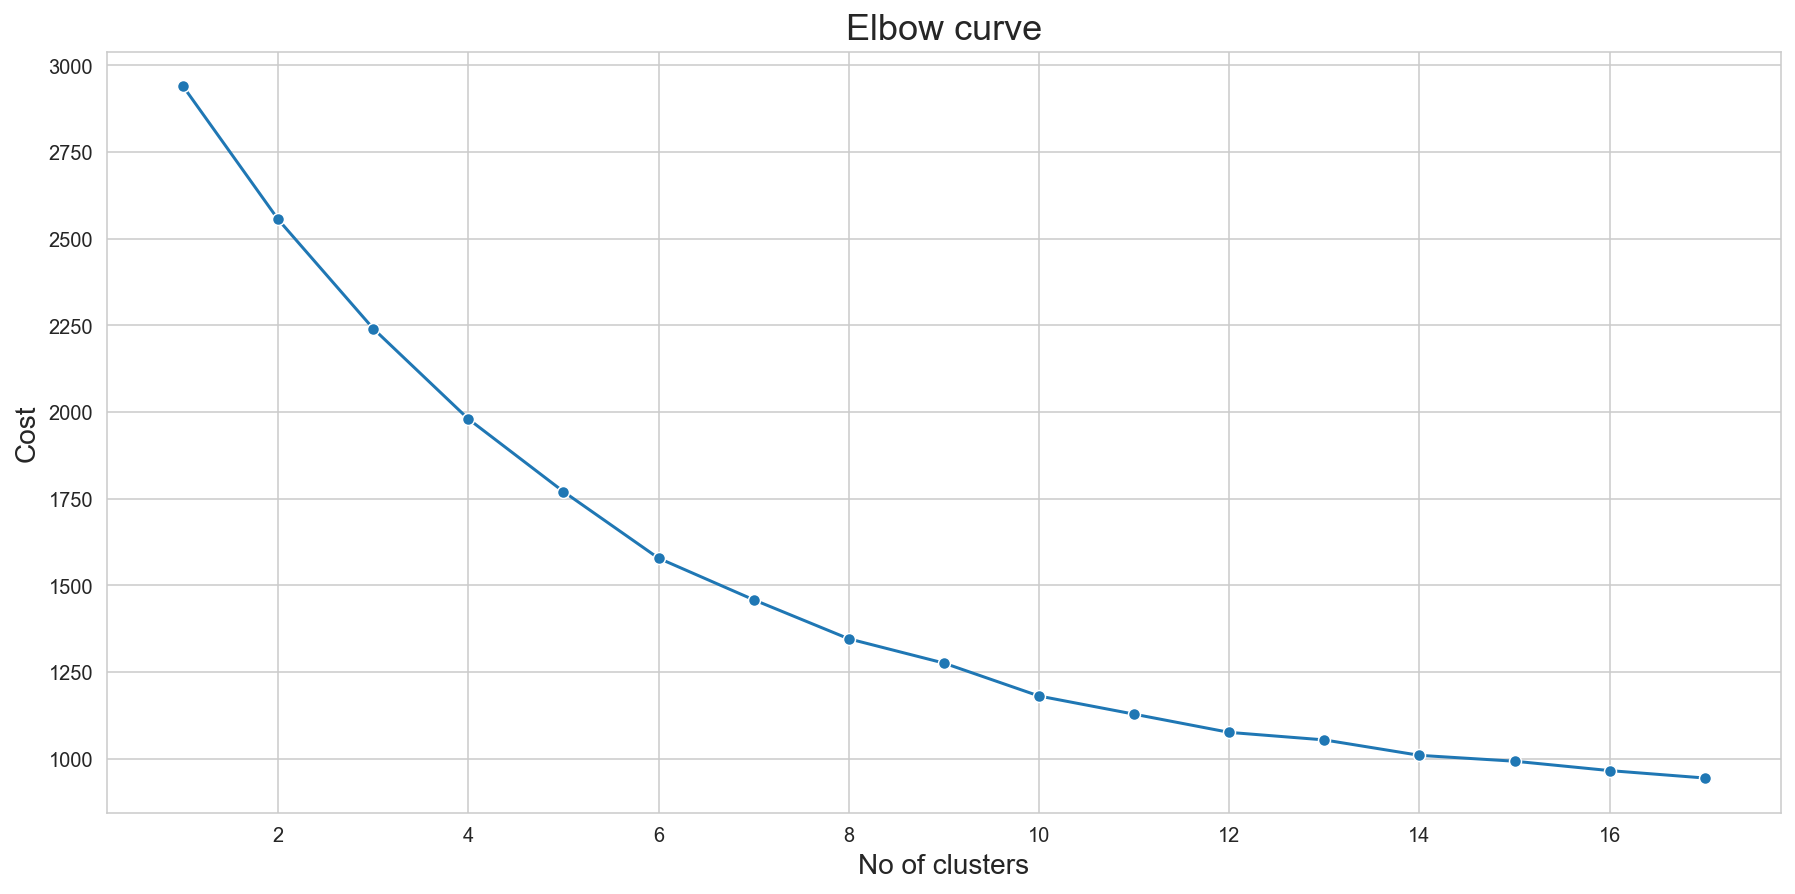

In [429]:
#Plot elbow plot
sns.set_style("whitegrid")
plt.figure(figsize=(15, 7))
ax = sns.lineplot(x=no_clusters, y=error_metrics, marker="o", dashes=False)
ax.set_title('Elbow curve', fontsize=18)
ax.set_xlabel('No of clusters', fontsize=14)
ax.set_ylabel('Cost', fontsize=14)
#ax.set(xlim=(start-0.1, end+0.1))
plt.plot();

From the above elbow curve, we see that clusters between 10 to 12  would seem like the number of clusters that would be of interest.

In [492]:
#Let us go with 10 number of clusters

model = KPrototypes(n_clusters=5, init="Huang", random_state=42, verbose = 1)
clusters = model.fit_predict(X, categorical = cat_index)

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 172, ncost: 2023.6609262986058
Run: 1, iteration: 2/100, moves: 58, ncost: 2006.4158661177394
Run: 1, iteration: 3/100, moves: 13, ncost: 2002.1319407062192
Run: 1, iteration: 4/100, moves: 17, ncost: 1997.2469632656328
Run: 1, iteration: 5/100, moves: 4, ncost: 1996.3126108487795
Run: 1, iteration: 6/100, moves: 4, ncost: 1993.261790513326
Run: 1, iteration: 7/100, moves: 5, ncost: 1991.3993404803605
Run: 1, iteration: 8/100, moves: 10, ncost: 1989.2366329929077
Run: 1, iteration: 9/100, moves: 15, ncost: 1979.9279383263856
Run: 1, iteration: 10/100, moves: 6, ncost: 1978.2334187090391
Run: 1, iteration: 11/100, moves: 16, ncost: 1955.7367123507254
Run: 1, iteration: 12/100, moves: 42, ncost: 1867.7206791728931
Run: 1, iteration: 13/100, moves: 43, ncost: 1813.2642371000757
Run: 1, iteration: 14/100, moves: 34, ncost:

In [494]:
doctors_merge.drop(columns = ["DoctorID"]).columns

Index(['Complaint Type', 'Qty', 'Region', 'Category', 'Rank', 'Incidence rate',
       'R rate', 'Experience', 'Purchases', 'Cluster Class'],
      dtype='object')

In [495]:
#Make centroids into a dataframe
pd.DataFrame(model.cluster_centroids_)

,0,1,2,3,4,5,6,7,8
0,2.9671980578738952,0.09148021351004514,0.2797693519949782,0.04453890051289945,0.13156668499457225,Correct,1 8 T3,Specialist,Titanium
1,-0.24955436651342017,-0.1927574387811485,0.9726823428973778,0.6451677615025687,-0.26600602833851844,No Complaints,1 19,Specialist,Platinum
2,0.18008978930003605,-0.09326501855601271,-0.06406580729291095,0.011271599111003618,2.6091524544370444,No Complaints,1 14,Specialist,Ambassador
3,-0.4043038799170634,6.111275083832148,0.09389809666392379,-0.23704504349600478,1.4102789229481831,No Complaints,1 10 T3,Specialist,Ambassador
4,-0.24037070598534382,-0.05770559068742014,-0.5180374975164896,-0.32558242765207945,-0.22949581928560395,No Complaints,1 13,Specialist,Ambassador


From the above, we can quickly spot the categorical variables that are used in the kmodes algorithm part of the kprototypes algorithm. However, some categorical variables seem to possess dominant features their category that is used in all clusters.

We should add the clusters into the dataframe as a label and seek to gain inisights on the datasets and the clusters formed.

In [496]:
doctors_merge["Cluster Class"] = clusters

In [497]:
doctors_merge.head()

,DoctorID,Complaint Type,Qty,Region,Category,Rank,Incidence rate,R rate,Experience,Purchases,Cluster Class
0,AHDCBA,No Complaints,0.0,4 15,Specialist,Ambassador,49.0,0.90,1.20,49,3
1,ABHAHF,No Complaints,0.0,1 8 T4,General Practitioner,Ambassador,37.0,0.00,0.00,38,3
2,FDHFJ,No Complaints,0.0,1 9 T4,Specialist,Ambassador,33.0,1.53,0.00,34,3
3,BJJHCA,No Complaints,0.0,1 10 T3,Specialist,Ambassador,28.0,2.03,0.48,29,3
4,FJBEA,No Complaints,0.0,1 14 T4,Specialist,Ambassador,23.0,0.96,0.75,24,3


In [498]:
doctors_merge.tail()

,DoctorID,Complaint Type,Qty,Region,Category,Rank,Incidence rate,R rate,Experience,Purchases,Cluster Class
483,AIABDJ,Unknown,1.0,1 10,Specialist,Ambassador,2.18,0.80,0.77,35,2
484,BBAJCF,Incorrect,1.0,1 9 T4,Specialist,Ambassador,2.17,1.68,0.11,19,4
485,GGCFB,No Complaints,0.0,1 19 T4,Specialist,Ambassador,2.14,0.77,0.27,22,4
486,FDCEG,No Complaints,0.0,1 9,Specialist,Ambassador,2.13,0.84,0.32,25,4
487,EIEIB,No Complaints,0.0,1 13,Specialist,Ambassador,2.05,1.56,0.39,64,2


<AxesSubplot:xlabel='Cluster Class'>

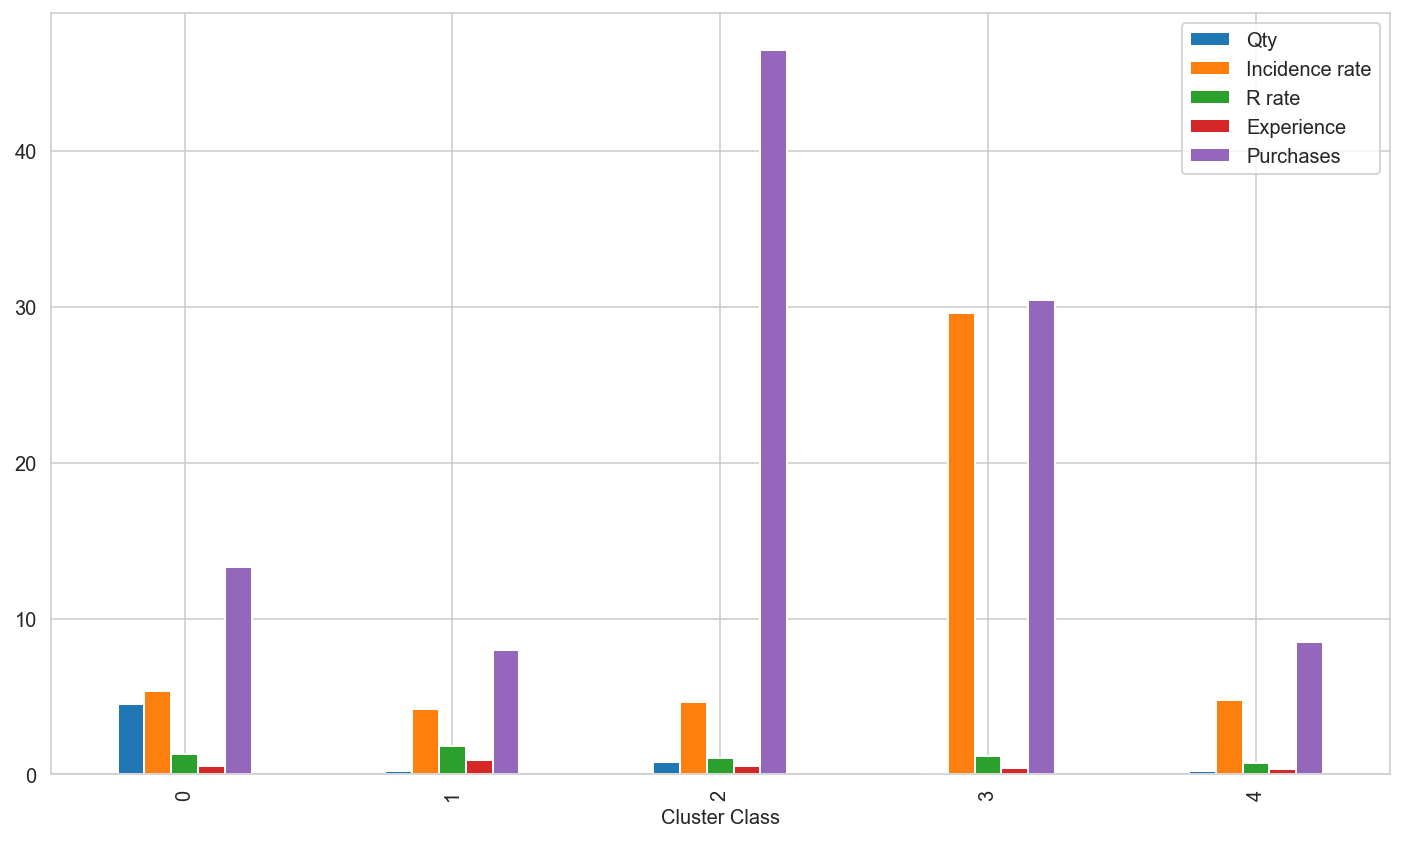

In [499]:
#Group by the cluster class

doctors_merge.groupby("Cluster Class")[["Qty", "Incidence rate", "R rate", "Experience", "Purchases"]].mean().plot(kind = "bar",
                                                                                                                  figsize = [12,7])

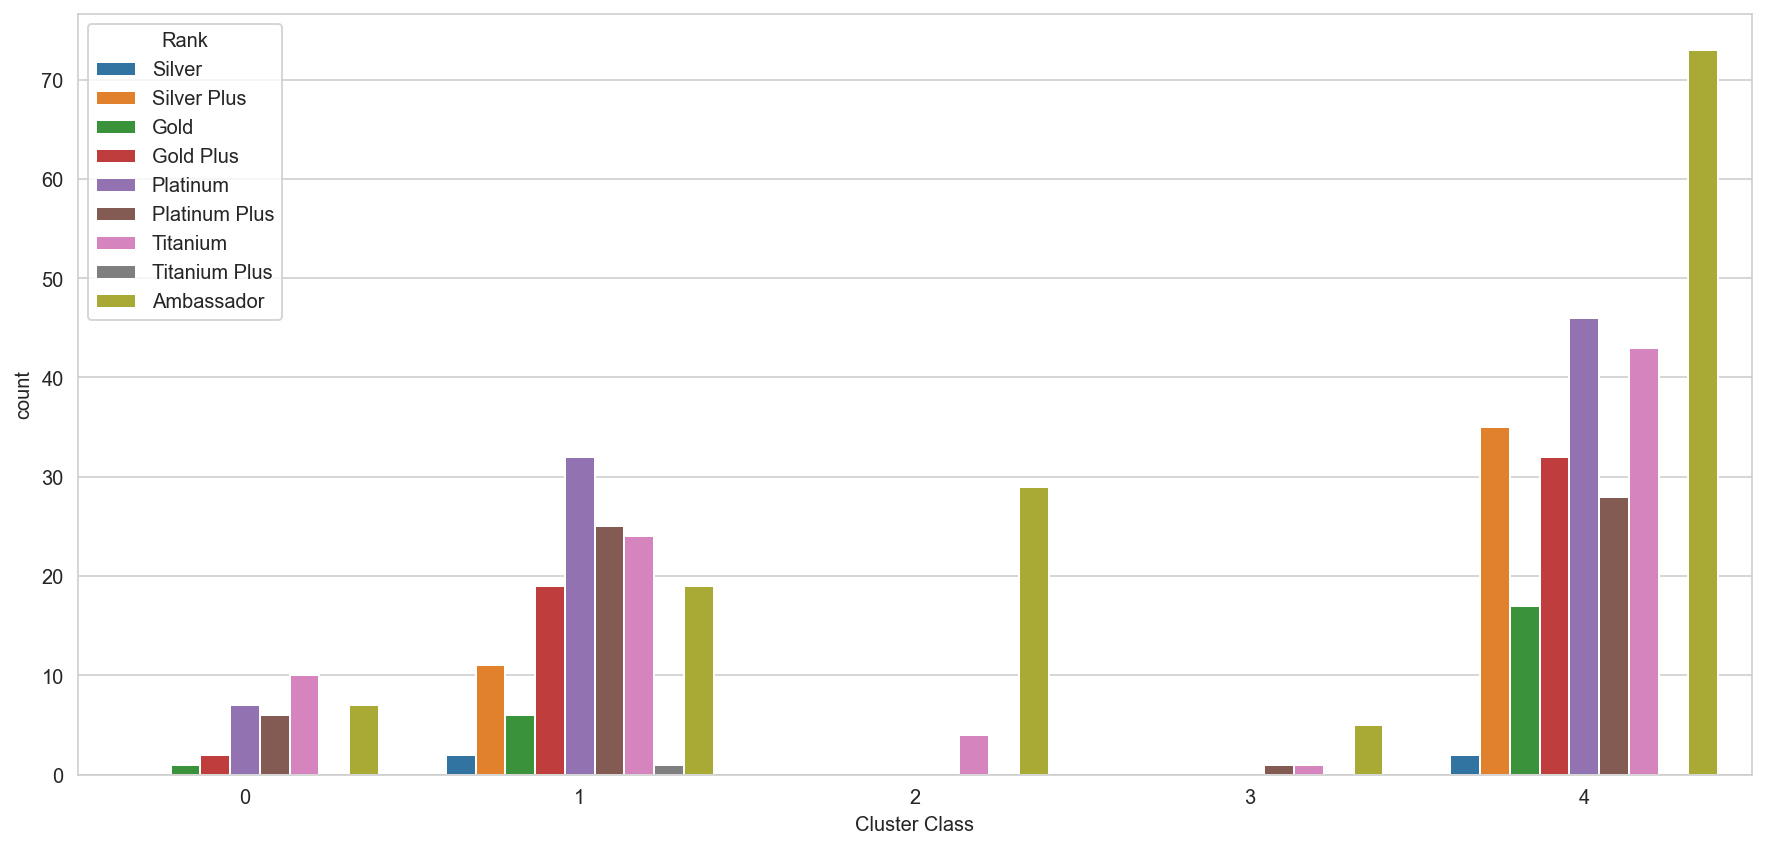

In [500]:
sns.set_style("whitegrid")
plt.figure(figsize=(15, 7))
sns.countplot(data=doctors_merge, x = "Cluster Class", hue = "Rank");

<AxesSubplot:xlabel='Experience', ylabel='Incidence rate'>

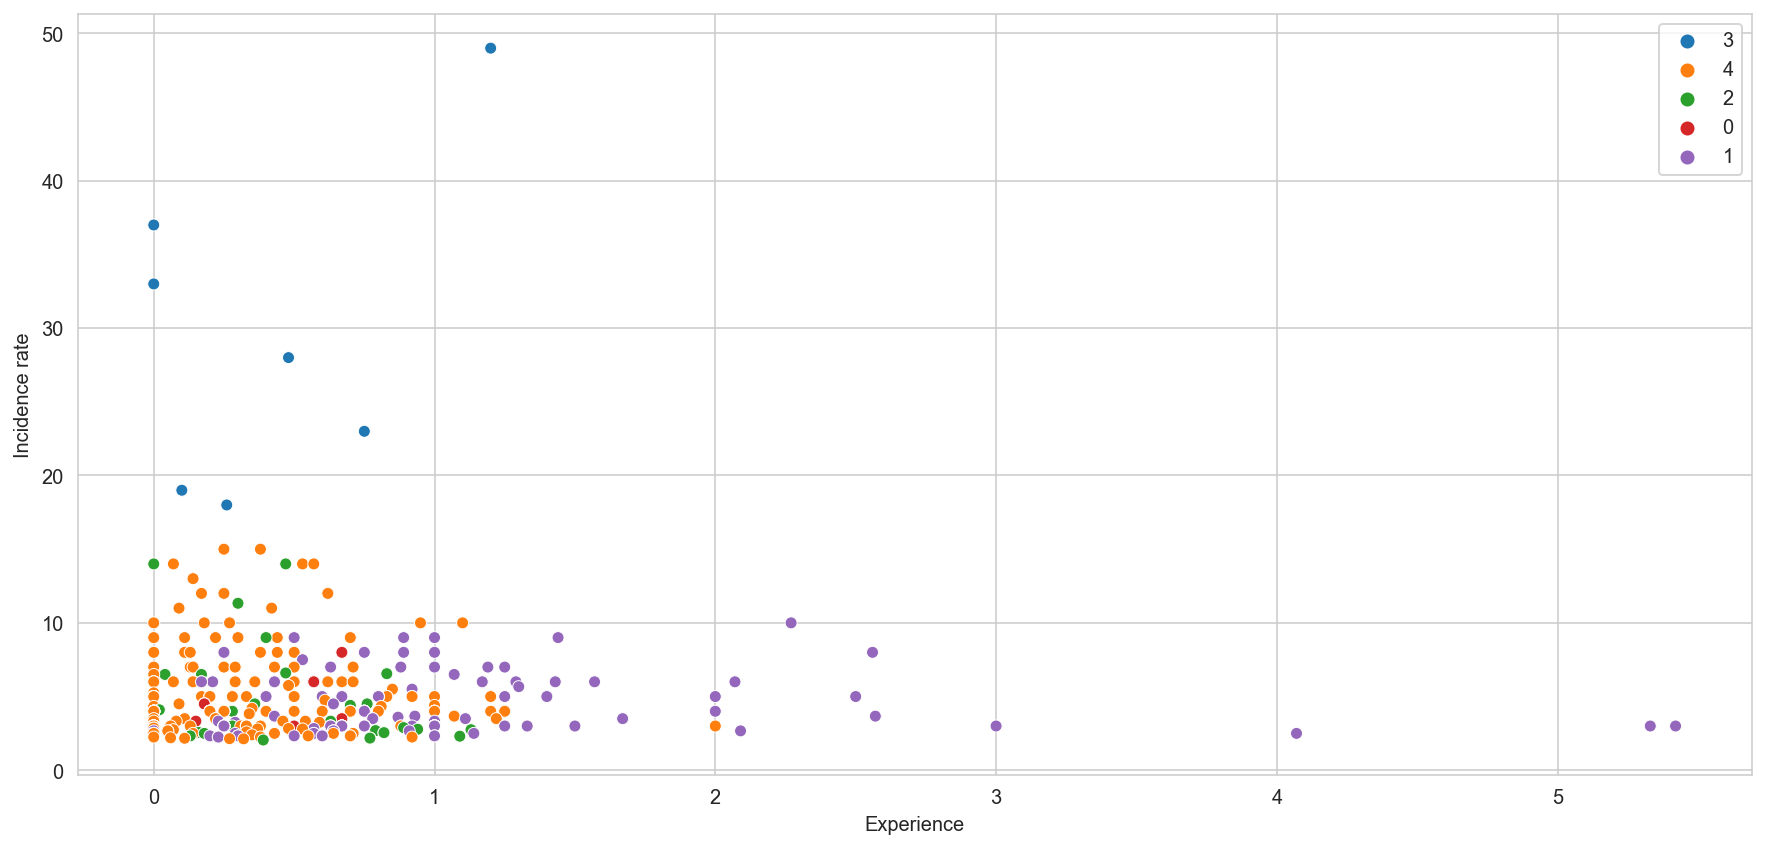

In [522]:
sns.set_style("whitegrid")
plt.figure(figsize=(15, 7))

sns.scatterplot(data=doctors_merge, x = "Experience", y = "Incidence rate", hue = clusters.astype(str))

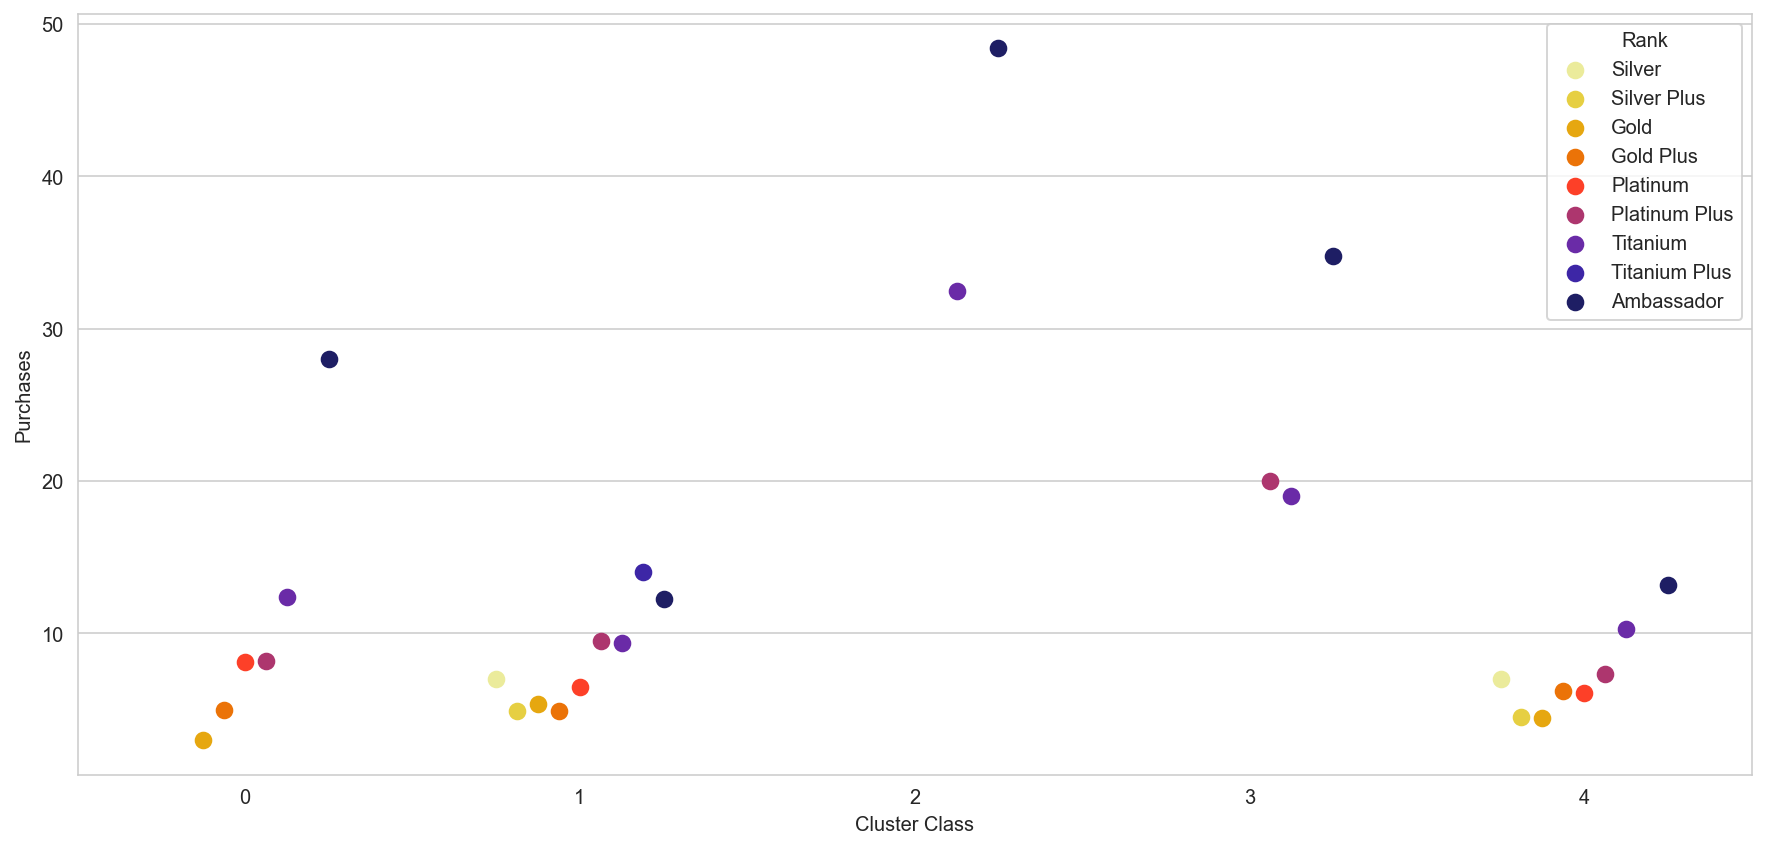

In [513]:
sns.set_style("whitegrid")
plt.figure(figsize=(15, 7))
sns.pointplot(data = doctors_merge, x = "Cluster Class",
             y = "Purchases", hue = "Rank", palette = "CMRmap_r",
             linestyles="", dodge = 0.5, ci = None);

From the plots above, we can go on to describe the clusters formed in the following ways:

**Cluster 0:** They have most of their mean purchases around 10+ but their ambassador ranking personnel have a mean purchase of close to 30. However this particular cluster have the highest complaints among all other clusters, which is significantly higher than all other clusters. The ranking do no begin at silver, it rather begins at gold and goes all the way to Ambassaor, skipping Titanium plus.

**Cluster 1:** Although the scatterplot is hard to interpret, we do see that that Cluster 1 distributed accross difference experience range. However, above experience of 1, not many kind of clusters are found there and the cluster well dominates the field. The average purchase is below 10. It contains all ranks with the silver rank up to the gold rank clusterred around the same number of purchase, less than 10 and the higher ranks clustered around region of 10 or greater but less than 20.

**Cluster 2:** They have an average purchase greater than 40, with only titanium rank and ambassador rank present in the cluster. The titanium rank have their average purchases greater than 30 and the average purchases of their ambassadors greater than 40 and close to 50.

**Cluster 3:** It contains only three rank, Platinium Plus, Titanium and Ambassadors with average purchase of 30. However, they are spectacular for their high incidence rate among all other clusters. By looking at the scatterplot also, we discover that most of the clusters are above 20 and are the highest incidence rate in all of the data points in the scatterplot.

**Cluster 4:** Cluster 4 looks a lot like cluster 1 with very little difference. The difference is

- The platinium rank seem to have fairly constant purchase made accross all clusters that they are present in.